## **Project: Prediction of Acute Aquatic Toxicity Toward Daphnia Magna**
- **Source**: Cassotti et al. (2014), Prediction of Acute Aquatic Toxicity 
Toward Daphnia magna by using the GA-kNN Method, Alternatives to Laboratory 
Animals Volume 42, Issue 1, March 2014
- **URL**: https://journals.sagepub.com/doi/epdf/10.1177/026119291404200106
- **Date**: 05/12/24
- **Goal**: Create a basic prediction model and a feature explainer

In [2]:
import logging
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import(
    train_test_split,
    GridSearchCV
)
#Importar tuberia.
from sklearn.pipeline import Pipeline
#Importar pre procesador.
from sklearn.preprocessing import MinMaxScaler
#Importar algoritmo, regresion.
from sklearn.neighbors import KNeighborsRegressor
#Importar metricas (en caso de regresiones)
from sklearn.metrics import(
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from sklearn.inspection import permutation_importance
from sklearn.utils import resample

#Bitacora
logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)


### **1. Data loading**
**Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [6]:
url = 'https://raw.githubusercontent.com/4GeeksAcademy/k-nearest-neighbors-project-tutorial/refs/heads/main/winequality-red.csv'
df_raw = pd.read_csv(url, sep=';')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [7]:
df_raw.sample(10, random_state=2025)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1462,6.8,0.640,0.03,2.3,0.075,14.0,31.0,0.99545,3.36,0.58,10.4,6
1162,8.5,0.320,0.42,2.3,0.075,12.0,19.0,0.99434,3.14,0.71,11.8,7
412,7.1,0.735,0.16,1.9,0.100,15.0,77.0,0.99660,3.27,0.64,9.3,5
527,7.0,0.380,0.49,2.5,0.097,33.0,85.0,0.99620,3.39,0.77,11.4,6
1176,6.5,0.880,0.03,5.6,0.079,23.0,47.0,0.99572,3.58,0.50,11.2,4
1139,8.2,0.510,0.24,2.0,0.079,16.0,86.0,0.99764,3.34,0.64,9.5,6
1556,6.6,0.880,0.04,2.2,0.066,12.0,20.0,0.99636,3.53,0.56,9.9,5
971,10.4,0.260,0.48,1.9,0.066,6.0,10.0,0.99724,3.33,0.87,10.9,6
88,9.3,0.390,0.44,2.1,0.107,34.0,125.0,0.99780,3.14,1.22,9.5,5
1128,10.0,0.430,0.33,2.7,0.095,28.0,89.0,0.99840,3.22,0.68,10.0,5


### **2. Data preprocessing**
**Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [9]:
df_baking = df_raw.copy()
df_baking.columns = df_baking.columns.str.lower().str.replace(' ', '_')
df = df_baking.copy()


### **3. Exploratory Data Analysis**
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [10]:
df_train, df_test = train_test_split(
    df, test_size=0.15, 
    random_state=2025
)
df_train, df_val = train_test_split(
    df_train, test_size=0.15,
    random_state=2025
)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1155 entries, 0 to 1154
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1155 non-null   float64
 1   volatile_acidity      1155 non-null   float64
 2   citric_acid           1155 non-null   float64
 3   residual_sugar        1155 non-null   float64
 4   chlorides             1155 non-null   float64
 5   free_sulfur_dioxide   1155 non-null   float64
 6   total_sulfur_dioxide  1155 non-null   float64
 7   density               1155 non-null   float64
 8   ph                    1155 non-null   float64
 9   sulphates             1155 non-null   float64
 10  alcohol               1155 non-null   float64
 11  quality               1155 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 108.4 KB


In [11]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed_acidity,1155.0,8.280779,1.731724,4.60000,7.10000,7.90000,9.1000,15.60000
volatile_acidity,1155.0,0.529459,0.181582,0.12000,0.39250,0.52000,0.6400,1.58000
citric_acid,1155.0,0.266857,0.195290,0.00000,0.09000,0.25000,0.4200,1.00000
residual_sugar,1155.0,2.547273,1.443612,0.90000,1.90000,2.20000,2.6000,15.50000
chlorides,1155.0,0.087674,0.049319,0.01200,0.07100,0.07900,0.0900,0.61100
free_sulfur_dioxide,1155.0,15.791775,10.545136,1.00000,7.00000,13.00000,21.0000,72.00000
total_sulfur_dioxide,1155.0,45.709091,32.448329,6.00000,22.00000,37.00000,60.0000,289.00000
density,1155.0,0.996745,0.001877,0.99007,0.99561,0.99676,0.9978,1.00369
ph,1155.0,3.316519,0.157597,2.74000,3.21000,3.32000,3.4050,4.01000
sulphates,1155.0,0.655931,0.170044,0.37000,0.55000,0.62000,0.7300,2.00000


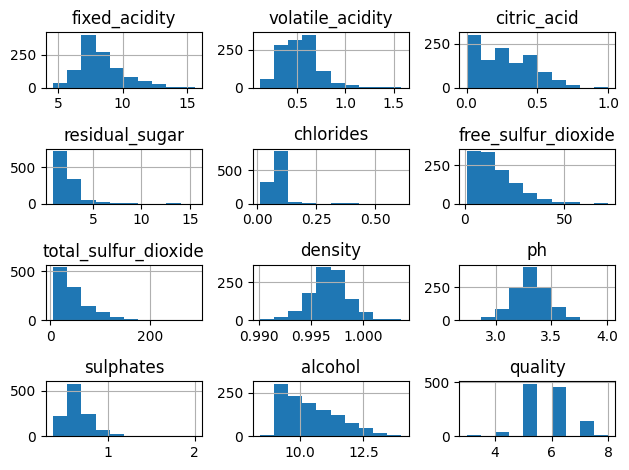

In [12]:
#Anlisis Univariado
df_train.hist()
plt.tight_layout()
plt.show()

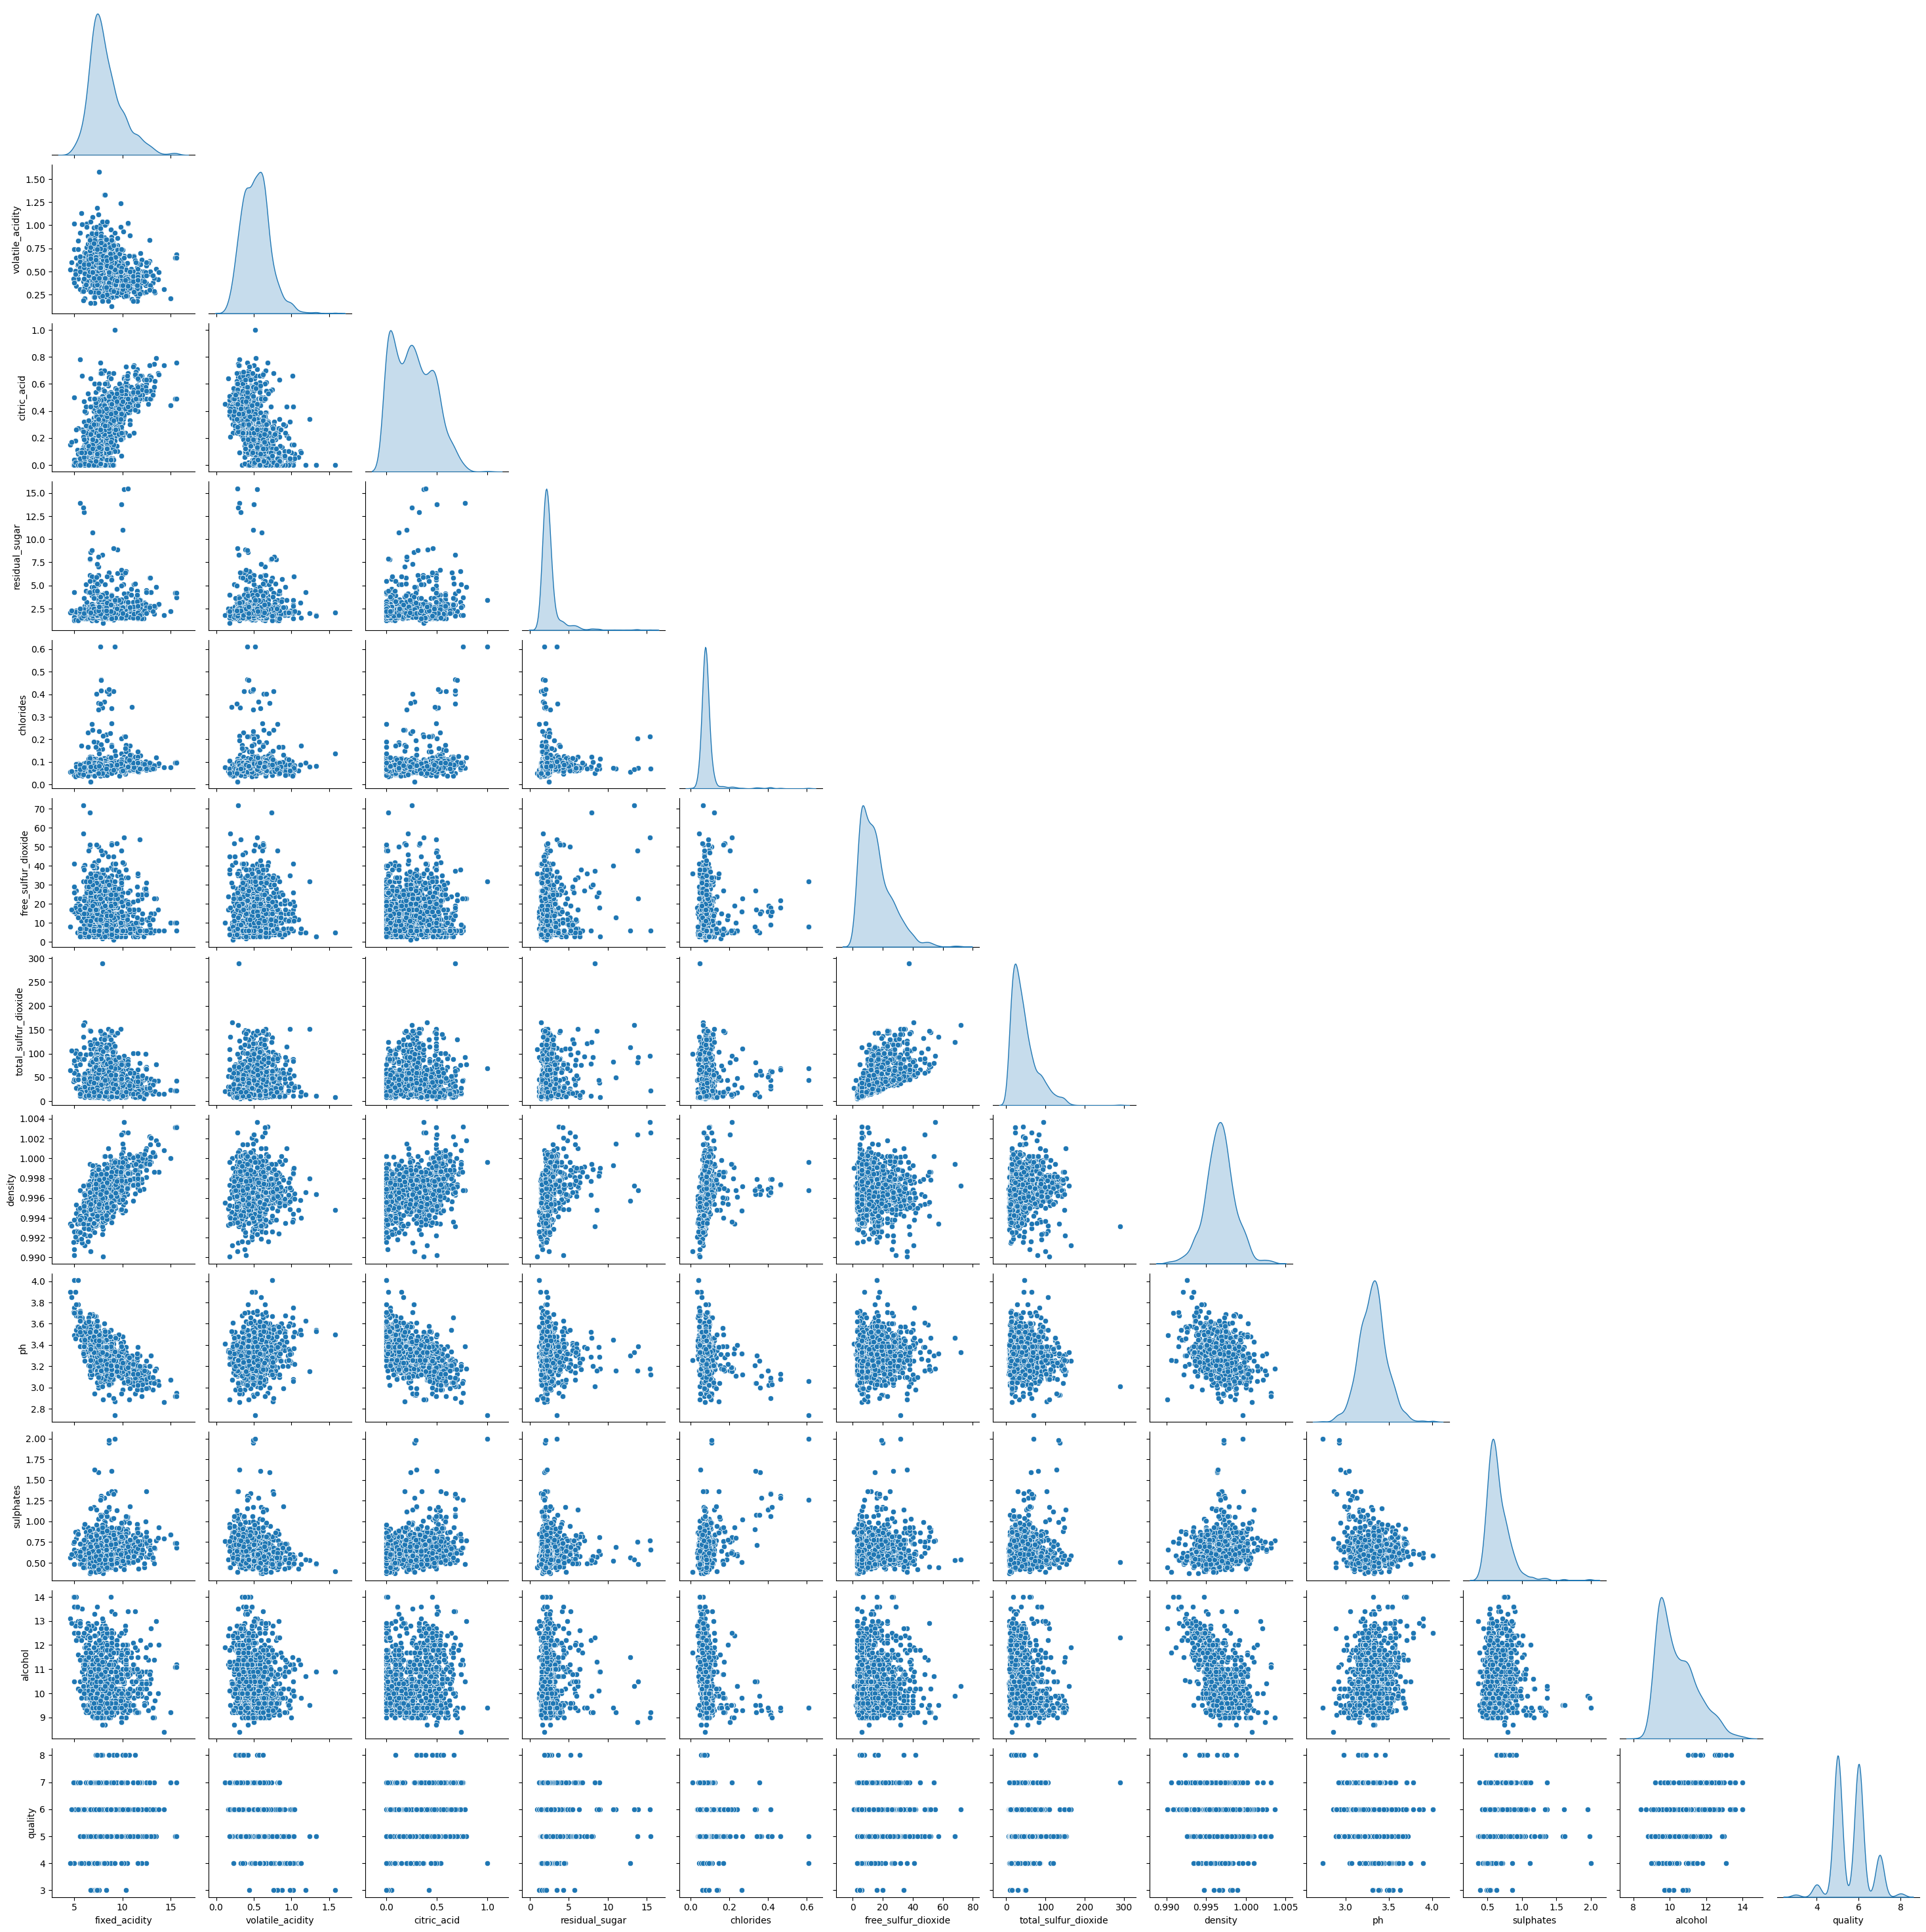

In [13]:
#Analisis Bivariado
sns.pairplot(df_train, diag_kind='kde',corner=True)
plt.show()

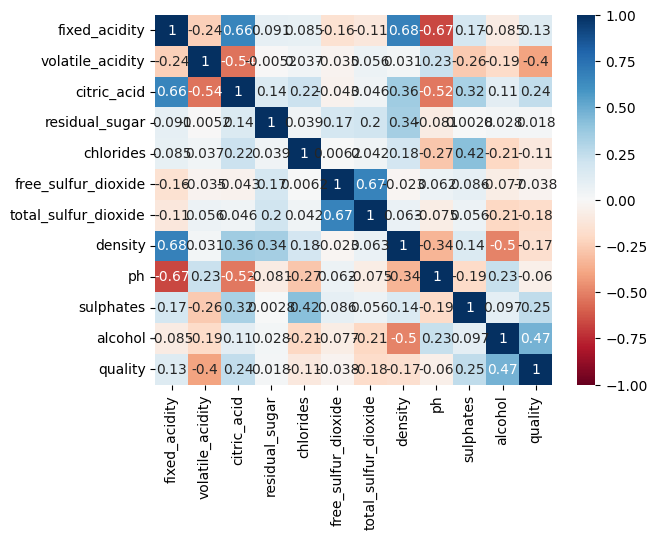

In [14]:
sns.heatmap(df_train.corr(), vmin=-1, vmax=1, cmap='RdBu',annot=True)
plt.show()

### **4. Machine learning**
**Objective**: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [15]:
X_train = df_train.drop(columns=['quality'])
y_train = df_train['quality']
X_val = df_val.drop(columns=['quality'])
y_val = df_val['quality']
X_test = df_test.drop(columns=['quality'])
y_test = df_test['quality']

In [18]:
#pipeline
reg_knn_p = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsRegressor())
])

reg_knn_cv = GridSearchCV(
    reg_knn_p,
    param_grid={
        'knn__n_neighbors':np.arange(3,31),
        'knn__weights':['uniform','distance'],
        'knn__p':[1,2]
    },
    cv=5,
    scoring='r2',
    n_jobs=-1
)

In [19]:
reg_knn_cv.fit(X_train,y_train)
reg_knn_cv.best_params_

{'knn__n_neighbors': np.int64(30), 'knn__p': 1, 'knn__weights': 'distance'}

In [20]:
#Metricas val
y_hat_val = reg_knn_cv.predict(X_val)
print(f'MSE:{mean_squared_error(y_val,y_hat_val):.2f}')
print(f'MAE:{mean_absolute_error(y_val,y_hat_val):.2f}')
print(f'RMSE:{np.sqrt(mean_absolute_error(y_val,y_hat_val)):.2f}')
print(f'R2:{r2_score(y_val,y_hat_val):.2f}')

MSE:0.39
MAE:0.42
RMSE:0.65
R2:0.44


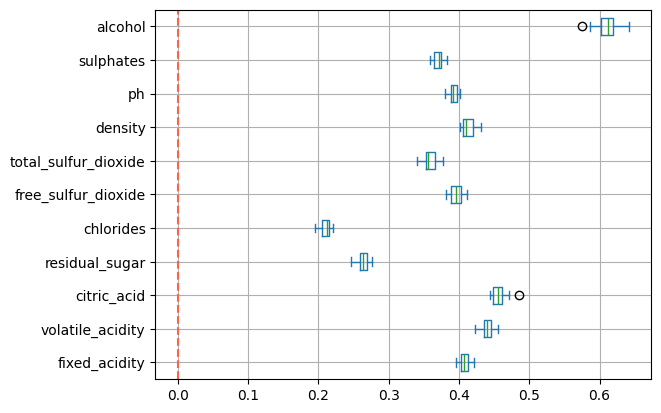

In [21]:
importance = permutation_importance(
    reg_knn_cv,
    X_train,
    y_train,
    n_repeats=25,random_state=2025
)
importance_df = pd.DataFrame(importance.importances.T, columns=X_train.columns)
ax = importance_df.plot.box(vert=False)
ax.axvline(x=0,linestyle='--',c='Tomato')
ax.grid(True)
plt.show()

In [22]:
#Metricas TEST
y_hat_test = reg_knn_cv.predict(X_test)
print(f'MSE:{mean_squared_error(y_test,y_hat_test):.2f}')
print(f'MAE:{mean_absolute_error(y_test,y_hat_test):.2f}')
print(f'RMSE:{np.sqrt(mean_absolute_error(y_test,y_hat_test)):.2f}')
print(f'R2:{r2_score(y_test,y_hat_test):.2f}')

MSE:0.33
MAE:0.40
RMSE:0.63
R2:0.42


In [24]:
# Use the best fitted estimator from GridSearchCV
best_knn = reg_knn_cv.best_estimator_

def bootstrap_model(model, X_train, y_train, X_test, y_test, n_b=300):
    rmse_scores = []
    r2_scores = []
    for _ in range(n_b):
        idx = np.random.choice(len(X_train), size=len(X_train), replace=True)
        X_boot, y_boot = X_train.iloc[idx], y_train.iloc[idx]
        model.fit(X_boot, y_boot)
        y_temp = model.predict(X_test)
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_temp)))
        r2_scores.append(r2_score(y_test, y_temp))
    return {'RMSE': rmse_scores, 'R2': r2_scores}

# Run bootstrap on best model only
result = bootstrap_model(best_knn, X_train, y_train, X_test, y_test)


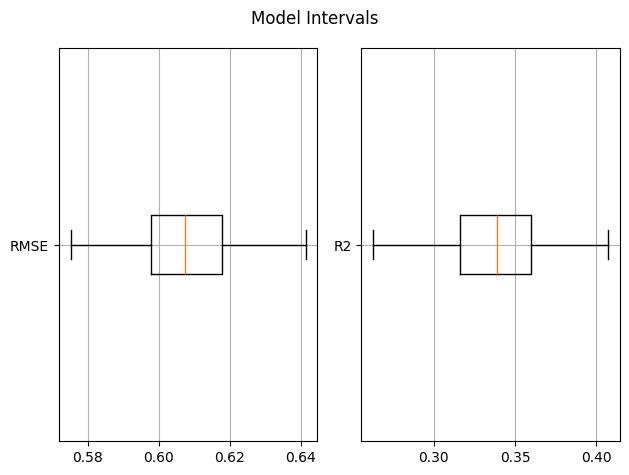

In [25]:
fig, ax = plt.subplots(1,2)
ax[0].boxplot(x=result['RMSE'],vert=False)
ax[0].grid(True)
ax[0].set_yticks([1],['RMSE'])
ax[1].boxplot(x=result['R2'],vert=False)
ax[1].grid(True)
ax[1].set_yticks([1],['R2'])
plt.suptitle('Model Intervals')
plt.tight_layout()
plt.show()

In [26]:
ci_low_rmse, ci_high_rmse = np.percentile(result['RMSE'],[2.5,97.5])
ci_low_r2, ci_high_r2 = np.percentile(result['R2'],[2.5,97.5])
print(f'RMSE mean:{np.mean(result["RMSE"])}, CI:{ci_low_rmse}-{ci_high_rmse}')
print(f'R2 mean:{np.mean(result["R2"])}, CI:{ci_low_r2}-{ci_high_r2}')

RMSE mean:0.6075614210053172, CI:0.5830978007259062-0.6302911690176647
R2 mean:0.3382359382938364, CI:0.28812257482951353-0.3907361208556416
